Dataset from: [**Transcriptome Analysis Reveals Nonfoamy Rather
Than Foamy Plaque Macrophages Are Proinflammatory
in Atherosclerotic Murine Models**](https://www.ahajournals.org/doi/pdf/10.1161/CIRCRESAHA.118.312804)

In [1]:
# Loading the packages

!pip install scanpy
!pip install harmonypy
!pip install leidenalg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.9/118.9 kB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.8/90.8 kB 10.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 50.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 8.2 MB/s eta 0:00:00
  Created wheel for umap-learn: filename=umap_learn-0.5.4-py3-none-any.whl size=86770 sha256=350292b2ff4349bd149a291abc35f0a1e7eac41e7879ab4c0b3666be11702ce3
  Stored in directory: /root/.cache/pip/wheels/fb/66/29/199acf5784d0f7b8add6d466175ab45506c96e386ed5dd0633
  Created wheel for session-info: filename=session_info-1.0.0-py3-none-any.whl size=8026 sha256=49b0bb35896a77e751d7465a77d9419bcda16850d46289b7ea68276dca0520a9
  Stored in directory: /root/.cache/pip/wheels/6a

In [2]:
# Download the data

!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3215nnn/GSM3215435/suppl/GSM3215435_ldlr_ko_barcodes.tsv.gz
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3215nnn/GSM3215435/suppl/GSM3215435_ldlr_ko_genes.tsv.gz
!wget https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3215nnn/GSM3215435/suppl/GSM3215435_ldlr_ko_matrix.mtx.gz

--2023-10-30 19:04:37--  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3215nnn/GSM3215435/suppl/GSM3215435_ldlr_ko_barcodes.tsv.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.10, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16066 (16K) [application/x-gzip]
Saving to: ‘GSM3215435_ldlr_ko_barcodes.tsv.gz’

GSM3215435_ldlr_ko_ 100%[===================>]  15.69K  --.-KB/s    in 0.003s  

2023-10-30 19:04:37 (5.85 MB/s) - ‘GSM3215435_ldlr_ko_barcodes.tsv.gz’ saved [16066/16066]

--2023-10-30 19:04:37--  https://ftp.ncbi.nlm.nih.gov/geo/samples/GSM3215nnn/GSM3215435/suppl/GSM3215435_ldlr_ko_genes.tsv.gz
Resolving ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)... 130.14.250.7, 130.14.250.10, 2607:f220:41e:250::12, ...
Connecting to ftp.ncbi.nlm.nih.gov (ftp.ncbi.nlm.nih.gov)|130.14.250.7|:443... connected.
HTTP request sent, awaiting r

In [3]:
# Import packages

import os
import scanpy as sc
import scanpy.external as sce

In [4]:
!awk -v OFS='\t' '{print $1,$2, $3="Gene Expression"}' <(zcat GSM3215435_ldlr_ko_genes.tsv.gz) | gzip > GSM3215435_ldlr_ko_features.tsv.gz
!rm GSM3215435_ldlr_ko_genes.tsv.gz

In [5]:
os.mkdir('dataset')

os.replace("GSM3215435_ldlr_ko_barcodes.tsv.gz", "dataset/GSM3215435_ldlr_ko_barcodes.tsv.gz")
os.replace("GSM3215435_ldlr_ko_features.tsv.gz", "dataset/GSM3215435_ldlr_ko_features.tsv.gz")
os.replace("GSM3215435_ldlr_ko_matrix.mtx.gz", "dataset/GSM3215435_ldlr_ko_matrix.mtx.gz")

In [6]:
# Load UMI raw matrices to anndata objects

data = sc.read_10x_mtx(path='dataset', prefix='GSM3215435_ldlr_ko_')

In [7]:
# Let's calculate quality metrics

data.var['mt'] = data.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(data, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

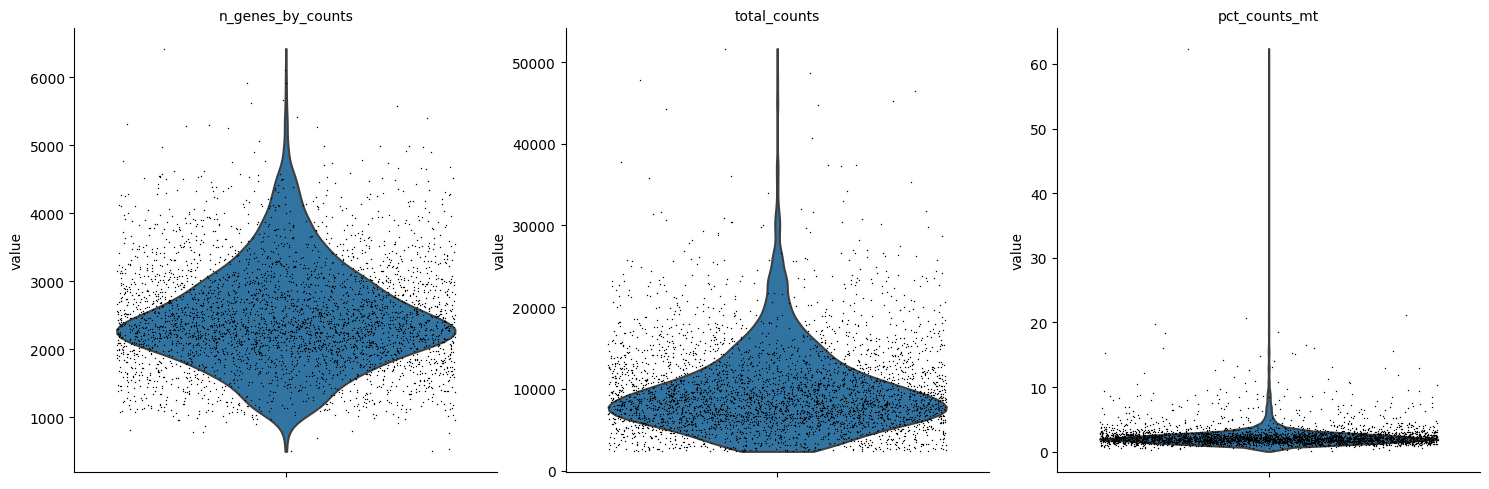

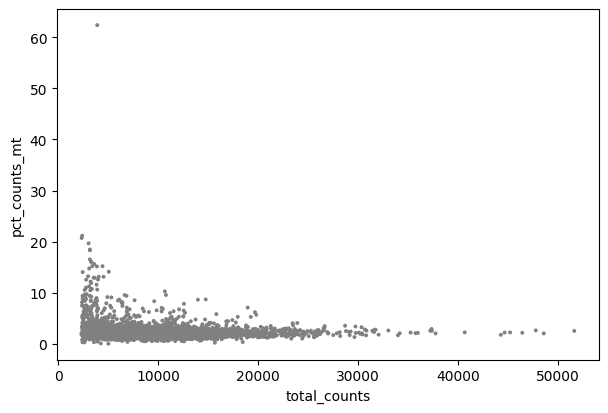

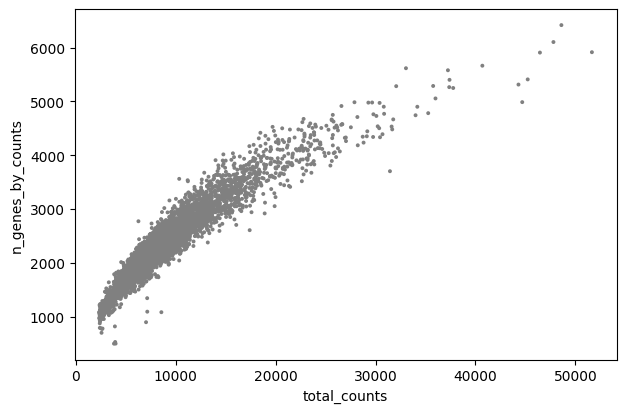

In [8]:
# And look at them

sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(data, x='total_counts', y='pct_counts_mt' )
sc.pl.scatter(data, x='total_counts', y='n_genes_by_counts')

**What thresholds would you choose to remove doubled cells?**

In [9]:
sc.pp.filter_cells(data, min_genes=1300)
sc.pp.filter_cells(data, max_counts=35000)
sc.pp.filter_genes(data, min_cells=20)

data = data[data.obs.pct_counts_mt < 5, :]

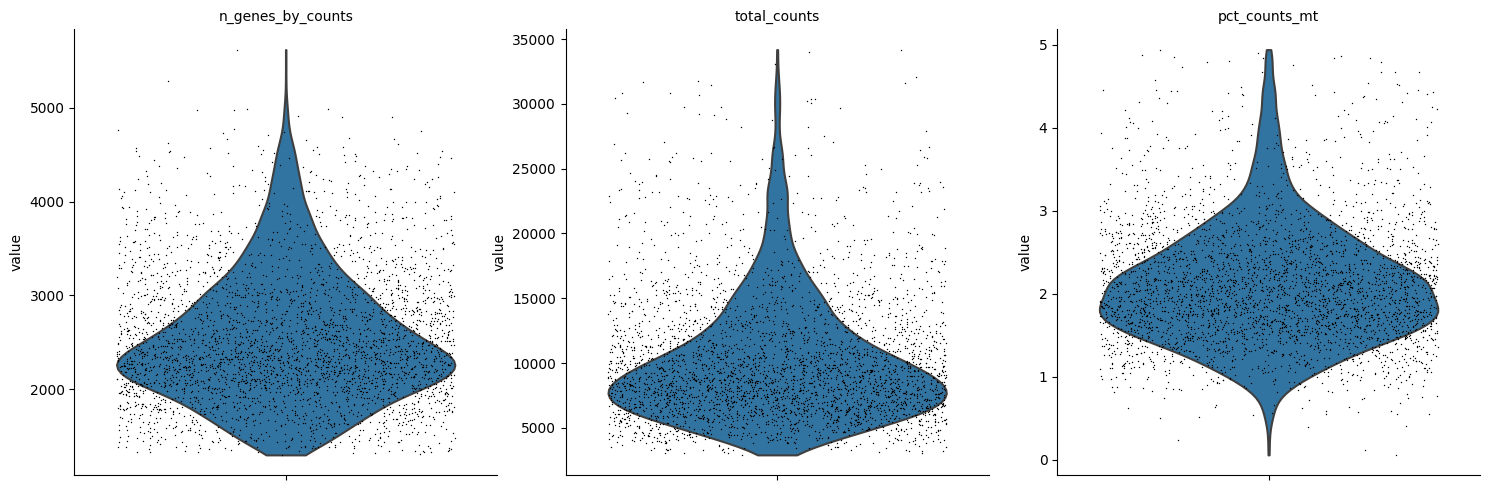

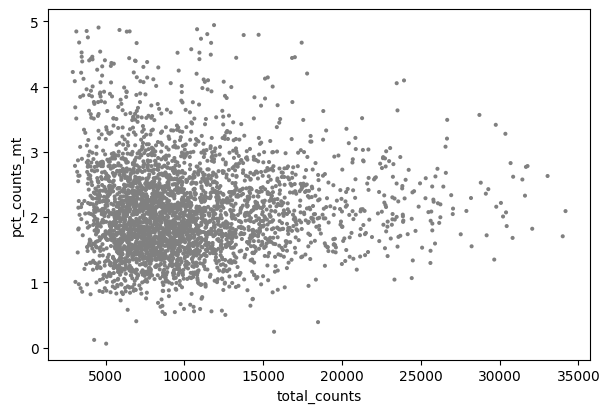

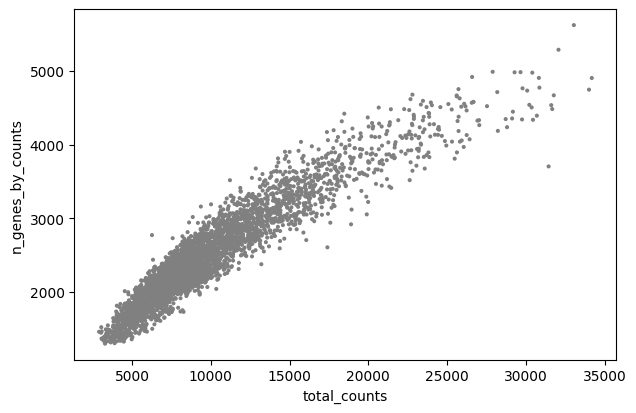

In [10]:
# Look after filtering

sc.pl.violin(data, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)
sc.pl.scatter(data, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(data, x='total_counts', y='n_genes_by_counts')

In [11]:
# Normalizing the data

sc.pp.normalize_total(data, target_sum=1e4)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_normalization.py:169: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [12]:
sc.pp.log1p(data)

In [13]:
# Choosing HVGs

sc.pp.highly_variable_genes(data, min_mean=0.0125, max_mean=3, min_disp=0.5)

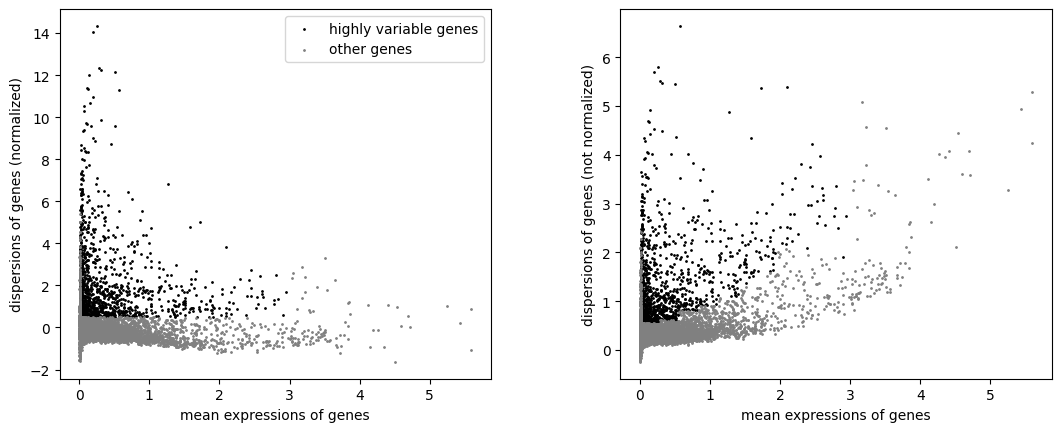

In [14]:
# Plotting to show how the HVGs were chosen

sc.pl.highly_variable_genes(data)

In [15]:
# Saving normalized data before subset

data.raw = data

In [16]:
# Subset only HVGs for dim reduction

data = data[:, data.var.highly_variable]

In [17]:
# Scaling the data (Z-score normalization)

sc.pp.scale(data, max_value=10)

/usr/local/lib/python3.10/dist-packages/scanpy/preprocessing/_simple.py:842: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [18]:
# PCA

sc.tl.pca(data)

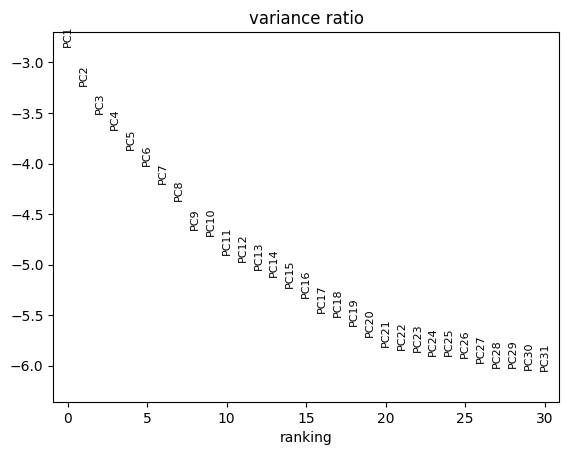

In [19]:
# Elbow plot to choose number of PCs for UMAP

sc.pl.pca_variance_ratio(data, log=True)

In [20]:
# Building the UMAP (2 steps)

sc.pp.neighbors(data, n_pcs=20, metric='cosine')

In [21]:
sc.tl.umap(data)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


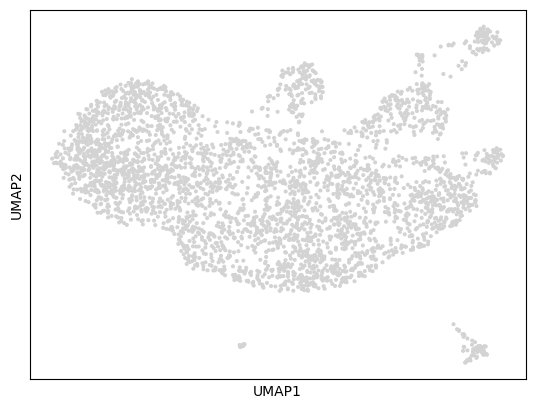

In [22]:
sc.pl.umap(data)

In [23]:
# Clustering data

sc.tl.leiden(data,  resolution=0.2)

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_tools/scatterplots.py:391: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


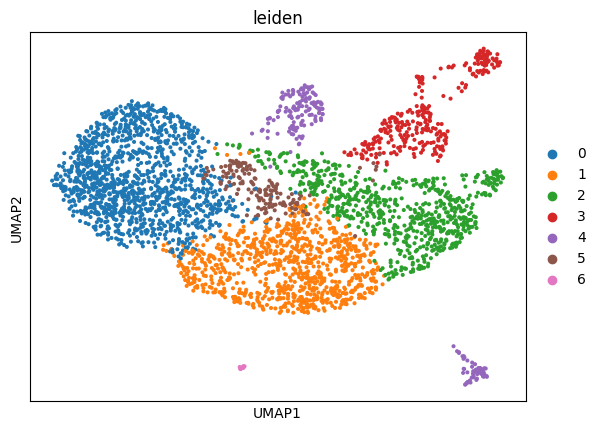

In [27]:
# And look at the clusters

sc.pl.umap(data, color=['leiden'])

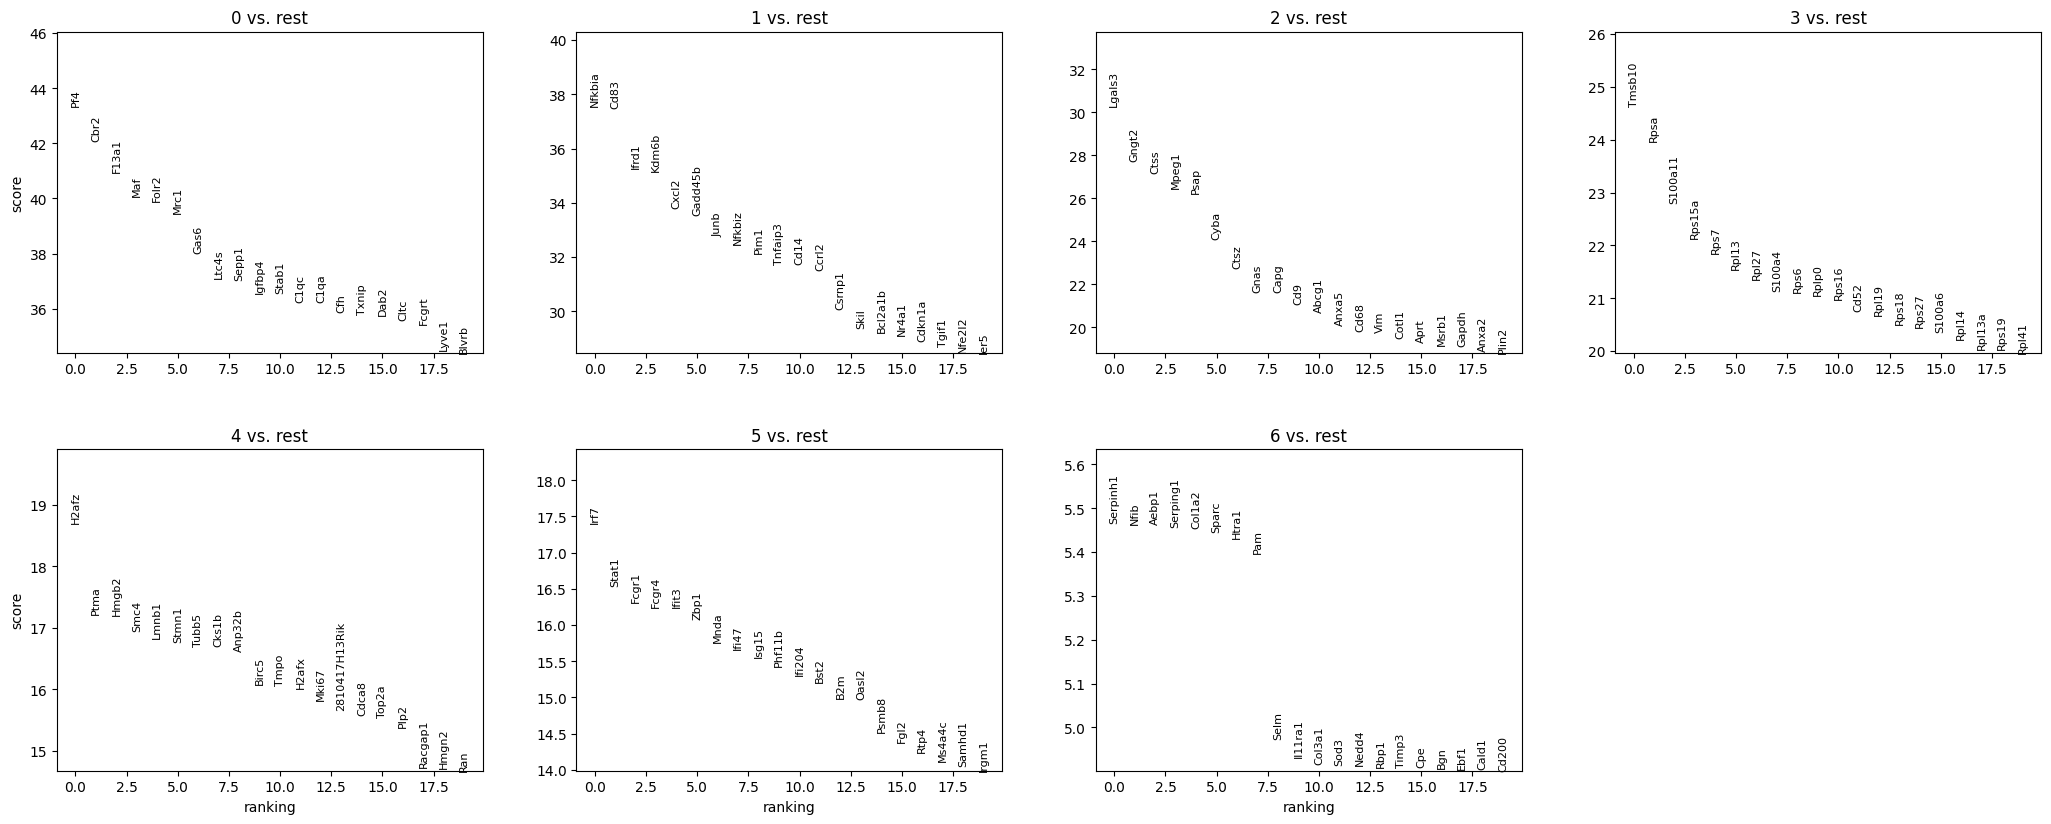

In [28]:
# Differential expression between the clusters

sc.tl.rank_genes_groups(data, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(data, n_genes=20, sharey=False)

In [29]:
sc.get.rank_genes_groups_df(data, group=['1']).head(n=10)

,names,scores,logfoldchanges,pvals,pvals_adj
0,Nfkbia,37.581955,3.061538,4.238015e-309,5.116979e-305
1,Cd83,37.474159,3.186654,2.428229e-307,1.465922e-303
2,Ifrd1,35.270592,3.190259,1.659036e-272,6.677066e-269
3,Kdm6b,35.160965,3.435744,7.903336e-271,2.385622e-267
4,Cxcl2,33.814880,3.687635,1.192060e-250,2.878587e-247
5,Gadd45b,33.525658,3.034737,2.038115e-246,4.101367e-243
6,Junb,32.755367,2.079005,2.546428e-235,4.392224e-232
7,Nfkbiz,32.458656,2.274031,4.088970e-231,6.171278e-228
8,Pim1,32.124489,2.424035,2.006675e-226,2.692066e-223
9,Tnfaip3,31.749304,3.096281,3.246226e-221,3.652409e-218


## Data examination for markers related to the entire population of hematopoietic cells

Let's look at the markers from paper:

/usr/local/lib/python3.10/dist-packages/scanpy/plotting/_dotplot.py:748: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  dot_ax.scatter(x, y, **kwds)


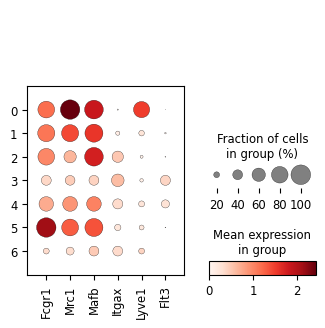

In [30]:
marker_genes = ["Fcgr1", "Mrc1", "Mafb", "Itgax", "Lyve1", "Flt3"]
sc.pl.dotplot(data, marker_genes, groupby='leiden')

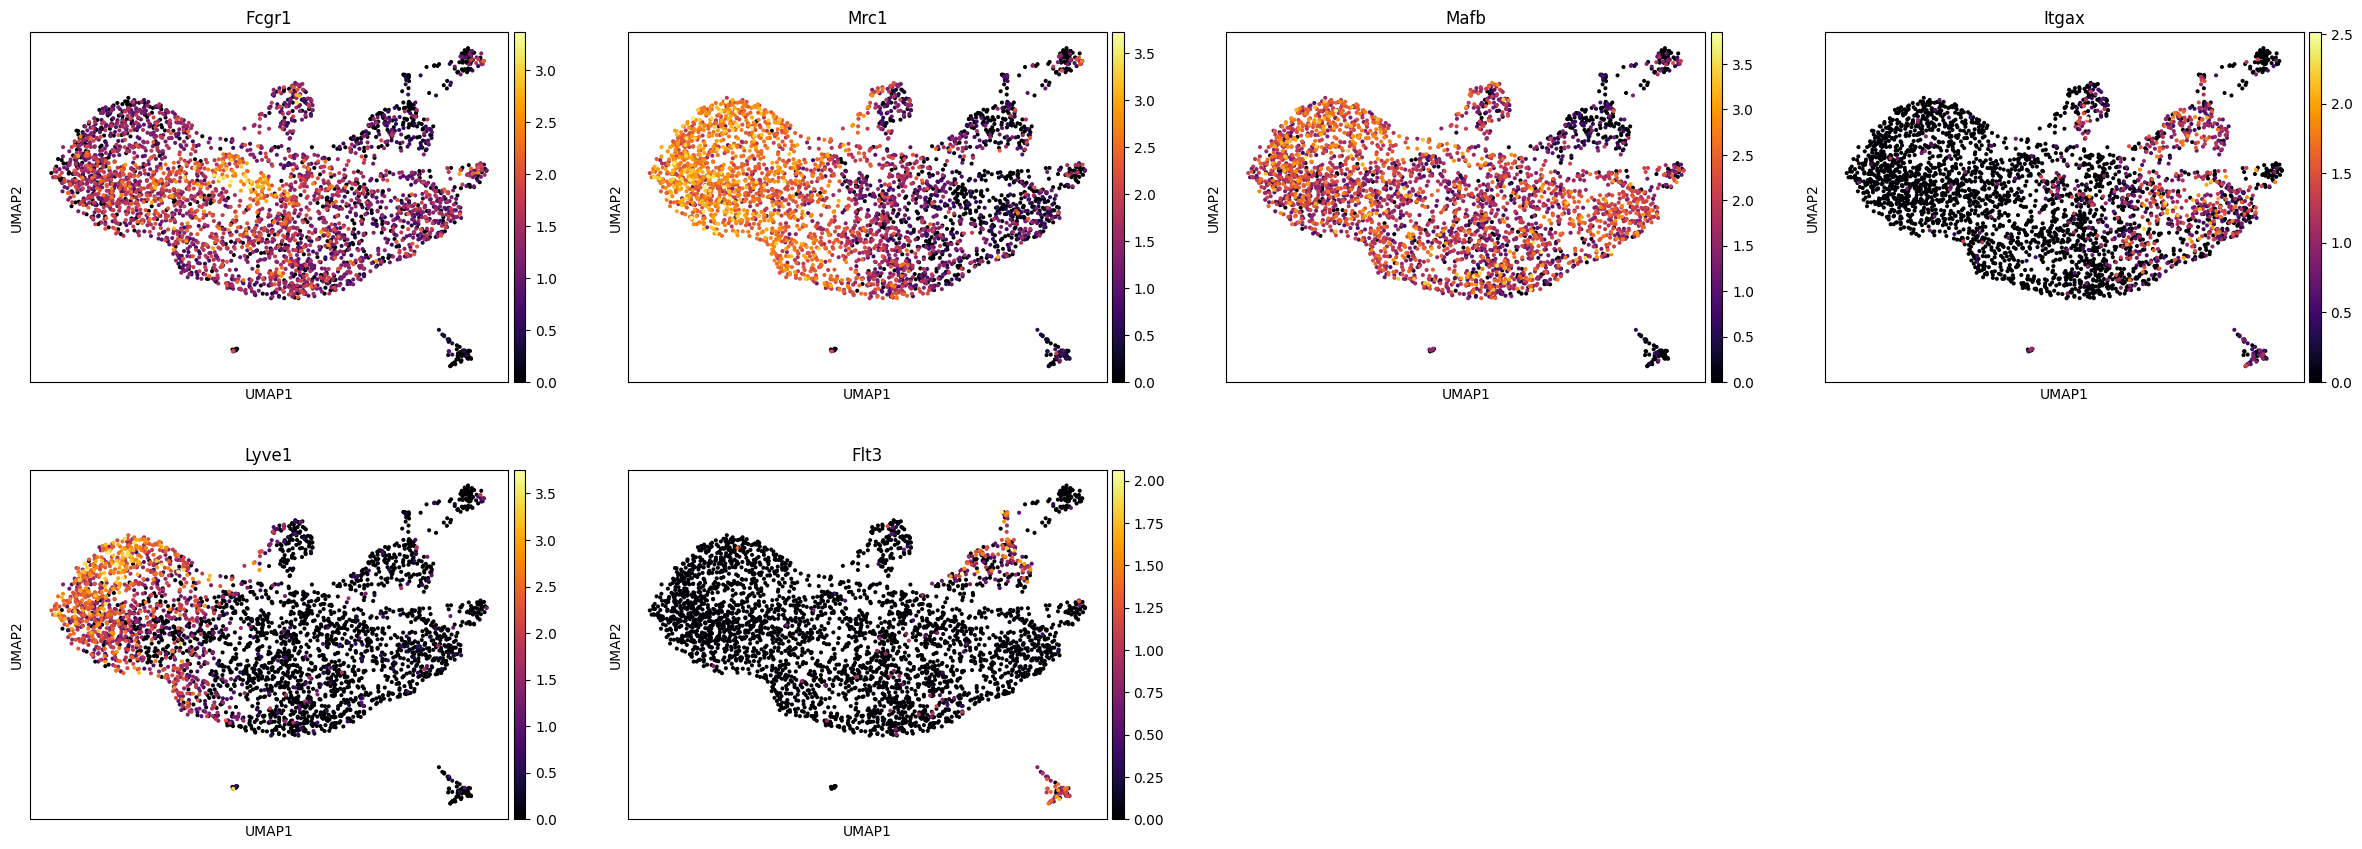

In [34]:
sc.pl.umap(data, color=["Fcgr1", "Mrc1", "Mafb", "Itgax", "Lyve1", "Flt3"], color_map='inferno')

##Expression of known cell-type-specific marker genes:

Several markers are associated with different cell types. For macrophages, well-known marker genes include Cd64 (Fcgr1) and Mafb. Interferon-stimulated genes, such as Mx1, Oasl1, and Stat1/2, are indicative of interferon-responsive macrophages. Genes linked to cell cycle regulation, such as Ccna2, Cdk1, and Cdk4, suggest the presence of proliferating macrophages. T cells are characterized by the presence of T-cell receptors (CD3e/d/g) and T-cell subset markers (CD8a and Foxp3). Additionally, genes required for dendritic cell (DC) differentiation, such as Flt3 and Zbtb46, provide markers for DCs. Let's now explore these cell markers further.

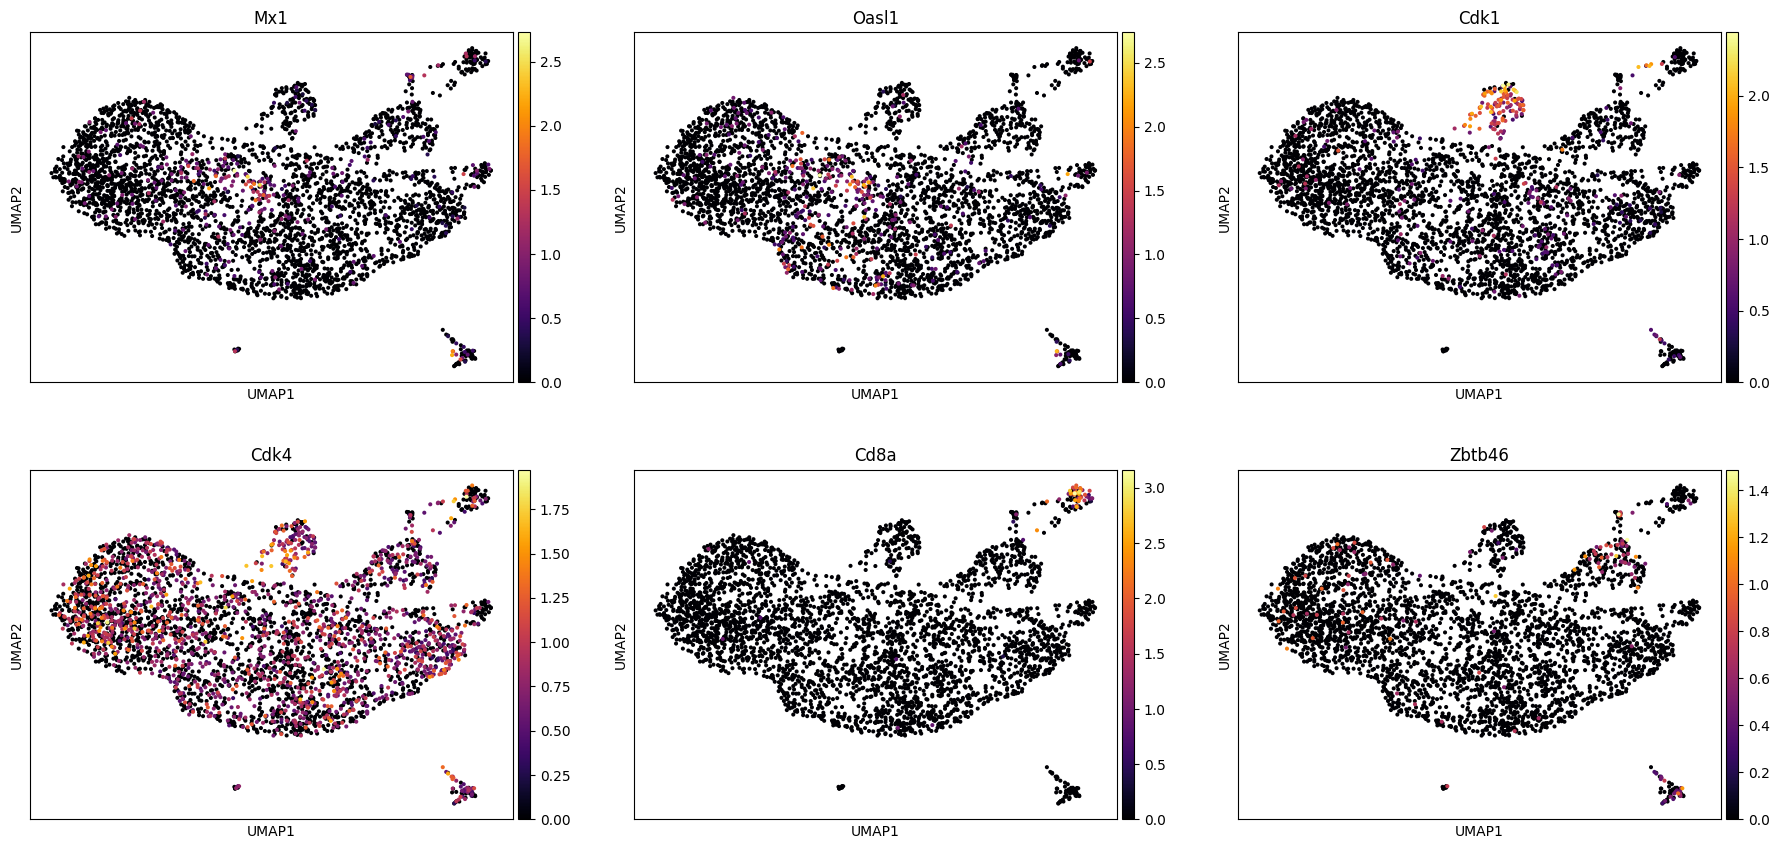

In [33]:
sc.pl.umap(data, color=['Mx1','Oasl1','Cdk1','Cdk4','Cd8a','Zbtb46'], color_map='inferno', ncols=3)

Conclusion by checking for cells population:

As observed, the findings exhibit a consistent alignment with each other. Furthermore, we can identify all the cell clusters that have been addressed in the article.